In [1]:
! pip install -q kaggle

In [2]:
 from google.colab import files
 

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Import Libraries


In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score,recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Dense, Conv2D, Conv1D,MaxPooling2D,Flatten, Dropout, BatchNormalization,Activation
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

import cv2
import keras
import os
import glob
import gc

import warnings
warnings.filterwarnings('ignore')


In [9]:
 base_dir = ('/content/chest_xray/chest_xray')

In [10]:
train='/content/chest_xray/chest_xray/train/'
test='/content/chest_xray/chest_xray/test/'
val='/content/chest_xray/chest_xray/val'

In [11]:
os.listdir(train)
train_n = train+'NORMAL/'
train_p = train+'PNEUMONIA/'

# Plot the Chest images

1342
normal picture title:  NORMAL2-IM-1328-0001.jpeg
pneumonia picture title: person1399_virus_2402.jpeg


Text(0.5, 1.0, 'Pneumonia')

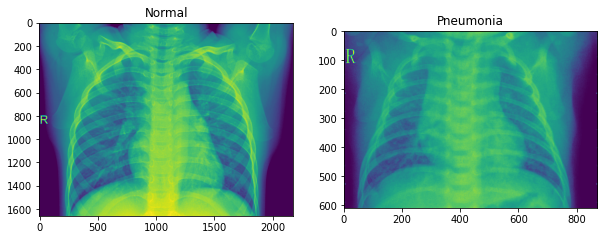

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')


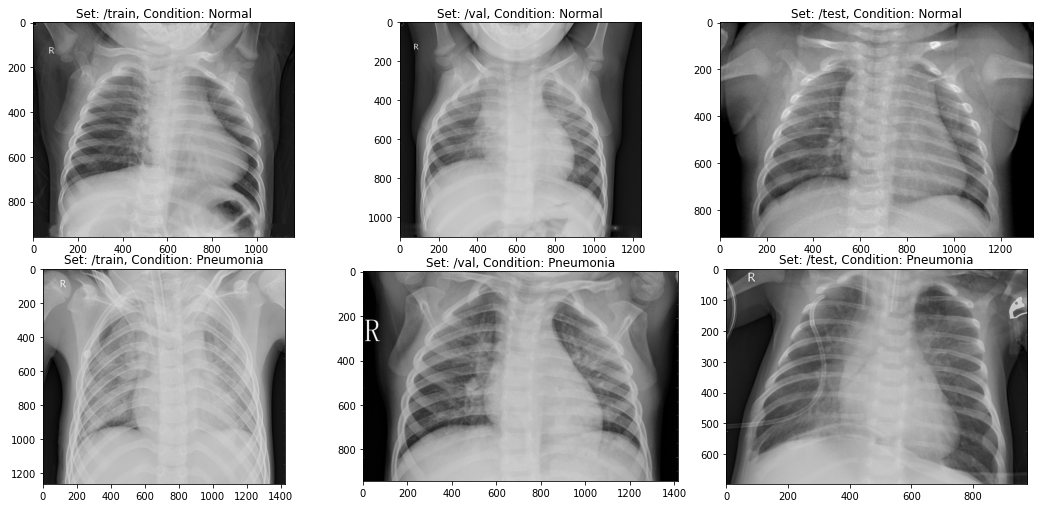

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['/train', '/val', '/test']):
    set_path = base_dir+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [14]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [15]:
train = get_training_data('/content/chest_xray/chest_xray/train/')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Split the data

In [16]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

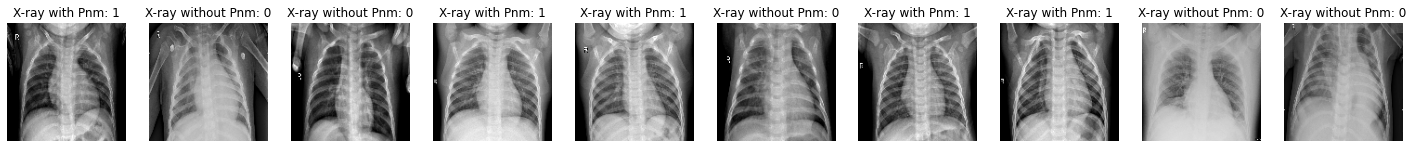

In [17]:
c = 10
resolution = 128
fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_train))
    num = y_train[n]
    word = "out" if num == 0 else "" 
    
    subplots[i].imshow(x_train[n].reshape((resolution, resolution)), cmap="gray")
    subplots[i].set_title(f"X-ray with{word} Pnm: {num}")
    subplots[i].axis("off")
plt.show()

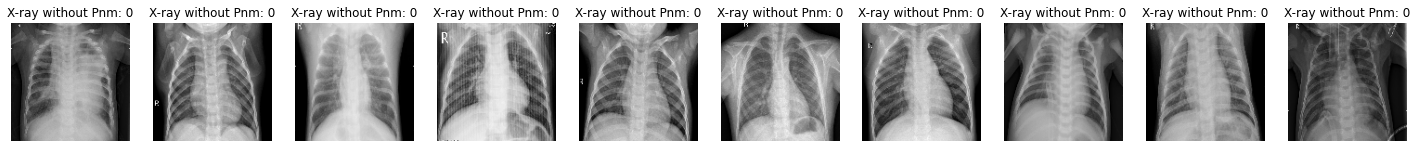

In [18]:
c = 10
resolution = 128
fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_test))
    num = y_train[n]
    word = "out" if num == 0 else "" 
    
    subplots[i].imshow(x_test[n].reshape((resolution, resolution)), cmap="gray")
    subplots[i].set_title(f"X-ray with{word} Pnm: {num}")
    subplots[i].axis("off")
plt.show()

In [19]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [20]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train).reshape((-1,1))

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val).reshape((-1,1))

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test).reshape((-1,1))

In [21]:
from keras.preprocessing.image import ImageDataGenerator, load_img

In [22]:
datagen = ImageDataGenerator(rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [23]:
import tensorflow as tf

# Rmsprop

In [24]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [25]:
from keras.callbacks import ReduceLROnPlateau

# Rmsprop using callbacks Funcation

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [27]:
hist = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 23s 78ms/step - loss: 0.8287 - accuracy: 0.8024 - val_loss: 15.9240 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 12s 74ms/step - loss: 0.3109 - accuracy: 0.8847 - val_loss: 34.0731 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 12s 73ms/step - loss: 0.2226 - accuracy: 0.9221 - val_loss: 33.7335 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 12s 74ms/step - loss: 0.1627 - accuracy: 0.9427 - val_loss: 17.6988 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 12s 74ms/step - loss: 0.1243 - accuracy: 0.9609 - val_loss: 10.6675 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/12
163/163 [==============================] - 12s 74ms/step - loss: 0.1203 - accuracy: 0.9623 - val_loss:

In [28]:
scor = model.evaluate((x_test),(y_test),verbose=2)

print("test los {:.4f}".format(scor[0]))
print("test acc {:.4f}".format(scor[1]))

20/20 - 1s - loss: 0.2776 - accuracy: 0.9231
test los 0.2776
test acc 0.9231


In [29]:
scor = model.evaluate((x_train),(y_train),verbose=2)

print("train los {:.4f}".format(scor[0]))
print("train acc {:.4f}".format(scor[1])) 

163/163 - 2s - loss: 0.2018 - accuracy: 0.9289
train los 0.2018
train acc 0.9289


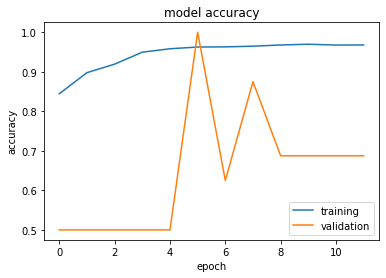

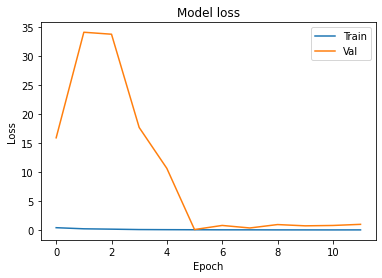

In [30]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='best')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

In [31]:
y_pred = model.predict_classes(x_test)
y_pred= y_pred.reshape(1,-1)[0]
y_pred[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.92      0.87      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



In [33]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[373,  17],
       [ 31, 203]])

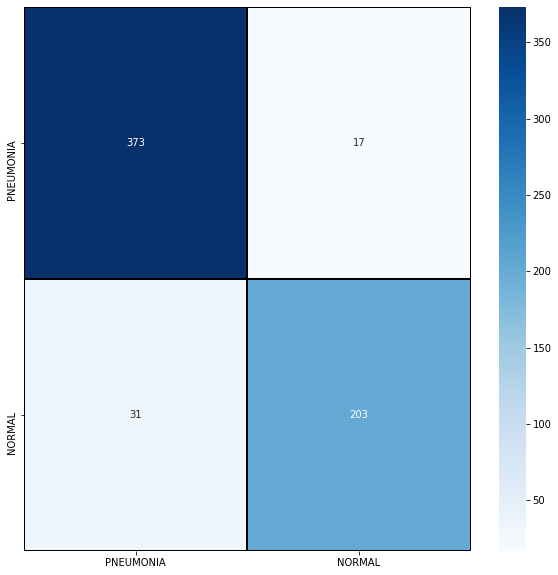

In [34]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# SGD using callbacks Funcation

In [35]:
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.1))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)       

In [36]:
hist2 = model1.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

scor = model.evaluate((x_test),(y_test),verbose=2)

print("test los {:.4f}".format(scor[0]))
print("test acc {:.4f}".format(scor[1]))

scor = model.evaluate((x_train),(y_train),verbose=2)

print("train los {:.4f}".format(scor[0]))
print("train acc {:.4f}".format(scor[1])) 

Epoch 1/12
163/163 [==============================] - 13s 74ms/step - loss: 0.4826 - accuracy: 0.8225 - val_loss: 2.9270 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 12s 72ms/step - loss: 0.2179 - accuracy: 0.9060 - val_loss: 4.5442 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 12s 71ms/step - loss: 0.1872 - accuracy: 0.9224 - val_loss: 5.5485 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 4/12
163/163 [==============================] - 12s 72ms/step - loss: 0.1663 - accuracy: 0.9333 - val_loss: 2.4460 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 11s 70ms/step - loss: 0.1532 - accuracy: 0.9409 - val_loss: 0.5900 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 12s 71ms/step - loss: 0.1391 - accuracy: 0.9454 - val_loss: 0.6508 - val_accuracy: 0.6250
Epoch 7/12
163/163 [==============================] - 1

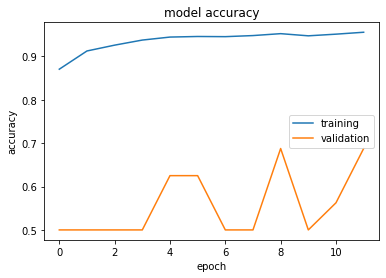

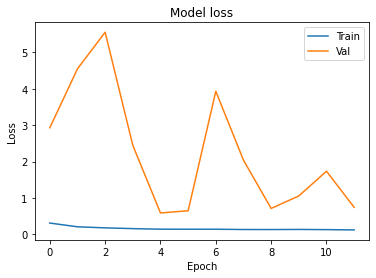

In [37]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='best')
plt.show()

plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

In [38]:
y_pred = model1.predict_classes(x_test)
y_pred= y_pred.reshape(1,-1)[0]
y_pred[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.95      0.93       390
   Normal (Class 1)       0.91      0.86      0.88       234

           accuracy                           0.92       624
          macro avg       0.91      0.90      0.91       624
       weighted avg       0.91      0.92      0.91       624



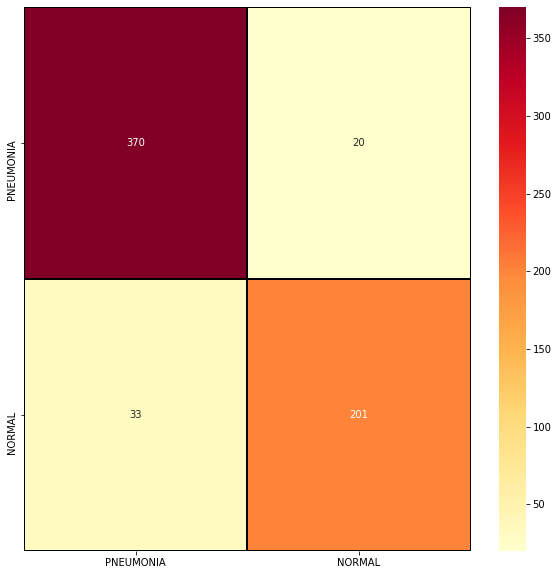

In [39]:
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "YlOrRd", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# Data Augmentation

In [40]:
for _set in ['train','val','test']:
  n_normal=len(os.listdir(base_dir+'/train'+'/NORMAL'))
  n_infect=len(os.listdir(base_dir+'/train'+'/PNEUMONIA'))
  print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 1342, pneumonia images: 3876
Set: test, normal images: 1342, pneumonia images: 3876


In [41]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=base_dir+'/train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=base_dir+'/test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(base_dir + '/test' + cond)):
            img = plt.imread(base_dir+'/test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [42]:
img_dims=150
batch_size=32
epochs=10

In [43]:
train_gen,test_gen,test_data,test_labels=process_data(img_dims,batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.models import Model

# Transfer Learning
## VGG16 Model

In [45]:
from keras.applications.vgg16 import VGG16

In [46]:
Num_classes=2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [47]:
x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=x)

model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [48]:
for layer in model3.layers[0:20]:
    layer.trainable = False

In [49]:
model3.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [50]:
hist3=model3.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 108s 625ms/step - loss: 0.3449 - accuracy: 0.8483 - val_loss: 0.2662 - val_accuracy: 0.8997
Epoch 2/10
163/163 [==============================] - 97s 595ms/step - loss: 0.1900 - accuracy: 0.9303 - val_loss: 0.2448 - val_accuracy: 0.9062
Epoch 3/10
163/163 [==============================] - 96s 591ms/step - loss: 0.1645 - accuracy: 0.9380 - val_loss: 0.2350 - val_accuracy: 0.9079
Epoch 4/10
163/163 [==============================] - 96s 589ms/step - loss: 0.1572 - accuracy: 0.9397 - val_loss: 0.2515 - val_accuracy: 0.8964
Epoch 5/10
163/163 [==============================] - 97s 592ms/step - loss: 0.1584 - accuracy: 0.9375 - val_loss: 0.2274 - val_accuracy: 0.9211
Epoch 6/10
163/163 [==============================] - 97s 596ms/step - loss: 0.1401 - accuracy: 0.9549 - val_loss: 0.3086 - val_accuracy: 0.8799
Epoch 7/10
163/163 [==============================] - 97s 593ms/step - loss: 0.1409 - accuracy: 0.9443 - val_loss: 0.2342 - val_a

In [51]:

from sklearn.metrics import accuracy_score, confusion_matrix

preds = model3.predict(test_data)

acc3 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc3))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist3.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[176  58]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 89.74358974358975%
Precision: 86.87782805429865%
Recall: 98.46153846153847%
F1-score: 92.3076923076923

TRAIN METRIC ----------------------
Train acc: 95.21


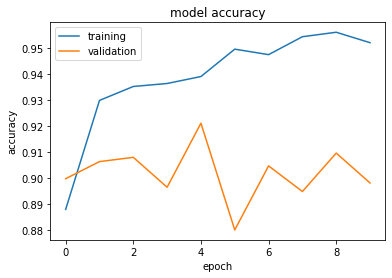

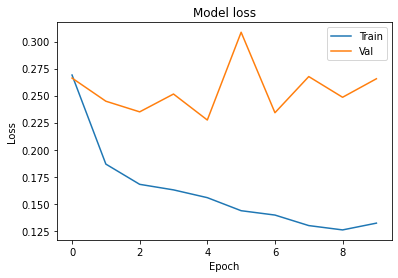

In [52]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='best')
plt.show()

plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

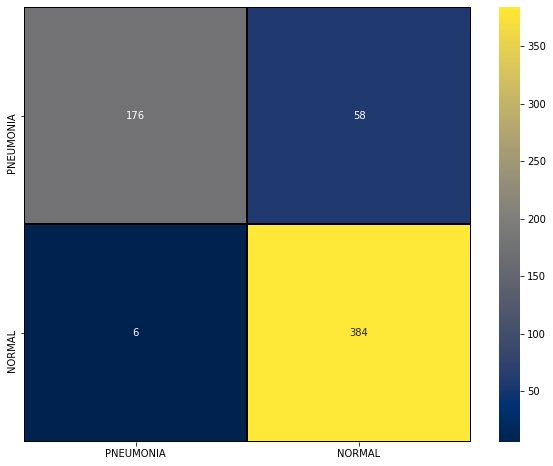

In [53]:
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "cividis", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Model VGG19

In [54]:
from keras.applications.vgg19 import VGG19

In [55]:

Num_classes=2
base_model1 = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=base_model.input, outputs=x)

model4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [56]:
for layer in model4.layers[0:20]:
    layer.trainable = False

In [57]:
model4.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [58]:
hist4=model4.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 97s 590ms/step - loss: 0.3446 - accuracy: 0.8463 - val_loss: 0.2844 - val_accuracy: 0.8914
Epoch 2/10
163/163 [==============================] - 97s 593ms/step - loss: 0.1948 - accuracy: 0.9233 - val_loss: 0.2461 - val_accuracy: 0.9079
Epoch 3/10
163/163 [==============================] - 96s 589ms/step - loss: 0.1807 - accuracy: 0.9312 - val_loss: 0.2368 - val_accuracy: 0.9046
Epoch 4/10
163/163 [==============================] - 96s 590ms/step - loss: 0.1724 - accuracy: 0.9367 - val_loss: 0.2629 - val_accuracy: 0.9013

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
163/163 [==============================] - 95s 584ms/step - loss: 0.1449 - accuracy: 0.9458 - val_loss: 0.2482 - val_accuracy: 0.9095
Epoch 6/10
163/163 [==============================] - 96s 587ms/step - loss: 0.1465 - accuracy: 0.9461 - val_loss: 0.2487 - val_accuracy: 0.9030
Epoch 7/10
163/163 [=============================

In [59]:
preds = model4.predict(test_data)

acc4 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc4))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist4.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[185  49]
 [  9 381]]

TEST METRICS ----------------------
Accuracy: 90.7051282051282%
Precision: 88.60465116279069%
Recall: 97.6923076923077%
F1-score: 92.92682926829268

TRAIN METRIC ----------------------
Train acc: 94.59


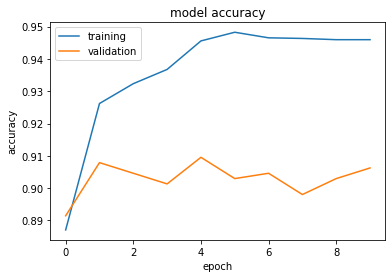

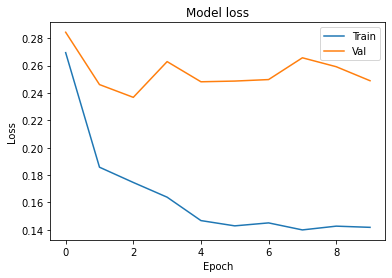

In [60]:
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='best')
plt.show()

plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

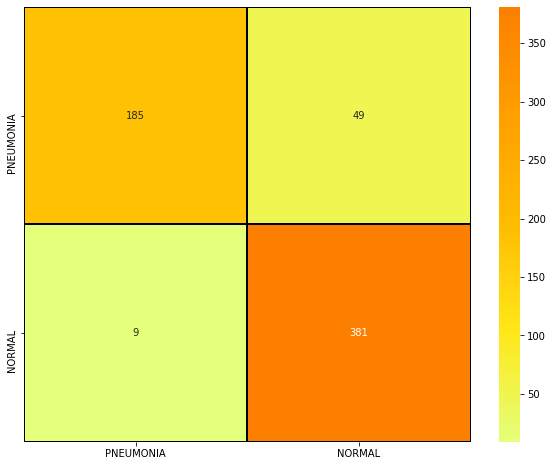

In [61]:
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Wistia", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Model Resnet50

In [62]:
from keras.applications.resnet50 import ResNet50

In [63]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [64]:
output=restnet.layers[-1].output

output = keras.layers.Flatten()(output)

restnet = Model(restnet.input,outputs=output)
for layer in restnet.layers[0:20]:
    layer.trainable = False
restnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [65]:
model5 = Sequential()
model5.add(restnet)
model5.add(Dense(256, activation='relu', input_dim=(150,150,3)))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 51200)             23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 36,728,193
Trainable params: 36,573,377
Non-trainable params: 154,816
_________________________________________________________________


In [66]:
hist5=model5.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 121s 694ms/step - loss: 1.0530 - accuracy: 0.8136 - val_loss: 13615.8652 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 115s 703ms/step - loss: 0.2385 - accuracy: 0.9070 - val_loss: 5343.3936 - val_accuracy: 0.6266
Epoch 3/10
163/163 [==============================] - 114s 696ms/step - loss: 0.2062 - accuracy: 0.9183 - val_loss: 0.5881 - val_accuracy: 0.8470
Epoch 4/10
163/163 [==============================] - 113s 691ms/step - loss: 0.1839 - accuracy: 0.9279 - val_loss: 2.0693 - val_accuracy: 0.8141
Epoch 5/10
163/163 [==============================] - 115s 703ms/step - loss: 0.1891 - accuracy: 0.9281 - val_loss: 0.7029 - val_accuracy: 0.6283

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
163/163 [==============================] - 115s 703ms/step - loss: 0.1929 - accuracy: 0.9219 - val_loss: 1.6424 - val_accuracy: 0.4243
Epoch 7/10
163/163 [================

In [67]:
preds = model5.predict(test_data)

acc5 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc5))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist5.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[177  57]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 89.90384615384616%
Precision: 87.07482993197279%
Recall: 98.46153846153847%
F1-score: 92.4187725631769

TRAIN METRIC ----------------------
Train acc: 95.59


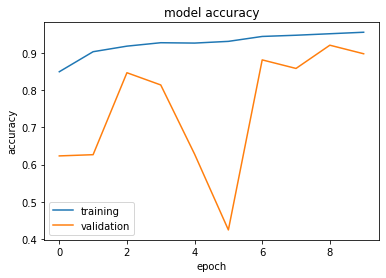

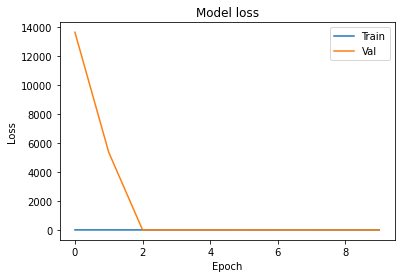

In [68]:
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='best')
plt.show()

plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

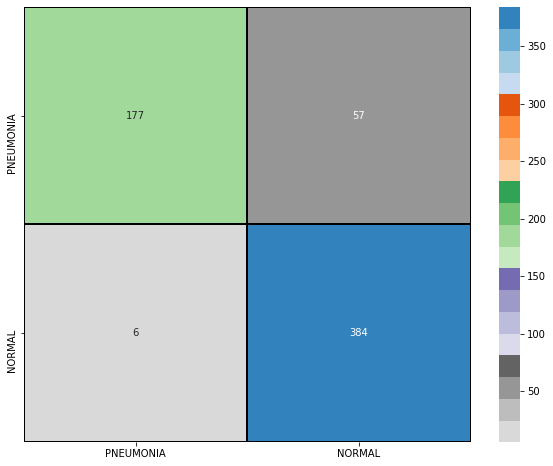

In [69]:
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "tab20c_r", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [70]:
train_accuracy=[]

for his in [hist,hist2,hist3,hist4,hist5]:

  X=his.history.get('accuracy')[-1] 
  train_accuracy.append(X)

In [71]:
 train_accuracy

[0.9677914381027222,
 0.9553297758102417,
 0.9520705342292786,
 0.9459356069564819,
 0.9559049010276794]